# Tutorial 2.1 Databases and SQL 

## Problem Set 

by Nadzeya Laurentsyeva @ nadzeya.laurentsyeva@econ.lmu.de

## Main take-aways from Tutorial 2.1 

* SQL might be a useful tool for working with big datasets: filtering, aggregating, merging 
* You can communicate with databases using Python 
* There are different SQL dialects (for different database management systems), does not make sense to memorize everything in detail, will need to check documentation/Stackoverflow
* Yet: common structure

        SELECT columns 
        FROM table1 
        WHERE (filtering condition) 
        GROUP BY (aggregation)
        HAVING (filtering condition for aggregated data)
        INNER\LEFT JOIN table2 
        ON column (merging) 
        ORDER BY (sorting) 
        LIMIT (return n-first records)
* Sub-queries (nested queries): a way to combine several queries 
    * Eg: WHERE can refer to the result of another survey (see example in the Tutorial)
    * We can get what we want, but long codes + execution time
* Alternatives to sub-queries
    * View: stores a (sub-)query (but doesn't execute it)
    * Temporary table: creates a temporary table with the result of a query
* Know where to see examples of basic commands in Python/Pandas to clean datasets and prepare them for regressions (rename columns, log-transform variables, create dummies, define functions and apply them to a dataframe) 


<div class="alert alert-block alert-info">
<b>Problem Set. </b> 
    
  
1. Reestimate the gravity model for online collaborations at the city level (for this you would need to go back to the SQL). Which additional insights can you learn? For this exercise: it is fine to focus on the intensive margin (only consider city pairs with non-zero collaborations).
    
2. Are there non-linearities in the distance penalty? How can this be checked? 
    
3. Which alternative specifications would you try? 
    
    
I encourage you to work on the problem set in teams. In the end, please, submit your responses to the form below (one form per team is enough) by <b>Monday, October 25. </b> 
    
If you tried to solve a question, but could not manage, please, write 'Can't solve (you can also specify a problem)'. The responses are anonymous and non-mandatory, but your feedback is extremely helpful :)  I will spend the first 15 minutes of our class on October 26 to go through the problem set and your questions. Solutions will be available after that. 
   

</div>

**Form to submit answers to the Problem Set** 
*  https://forms.gle/6hTyYSuncACgwzar9

In [1]:
# if needed: set the path to your folder, otherwise data are stored in the same folder as the notebook
# path = "C:/Users/nadzeya/Documents/teaching/Data_science_2021_ss/tutorial2" 
# os.chdir(path) #establish the path to your folder

# import the necessary packages
# if a package is missing, from Anaconda prompt: pip install package_name 
import os, sys, time
import pandas as pd
import numpy as np
import sqlite3, csv
import matplotlib.pyplot as plt

In [2]:
# create connection to the Database we created in the tutorial (if you don't have it, do the steps from the tutorial first)
conn = sqlite3.connect('github_DB.sqlite') 
cur = conn.cursor() # define cursor object to send commands to SQL, think of it as of a bridge between our database and notebook
print("Connection established", cur)

Connection established <sqlite3.Cursor object at 0x000001FCDD66F880>


In [3]:
# function to read query results (Note: if needed, you can modify it to allow for different conn/cur values)

# alternatively use pd.read_sql  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql.html

# represents the results of the query as a DataFrame
def view_query(script):
    out = pd.DataFrame(list(cur.execute(script))) # put in a dataframe 
    out.columns = [i[0] for i in cur.description] # assign column labels
    return out

## Preparing the GitHub dataset for regression analysis

_Example_ Let's now turn to the preparation of the GitHub dataset for the analysis. 

It is possible to prepare the dataset by writing one long query, but for this lecture it is better to go step by step using views and temporary tables. As an exercise, you can try to combine the queries together. 

    Owners: Owner id, Project id (projects) -- Long/Lat (users on owner id) -- Commits (commits on project id)
    Users: User id, Country code -- Commits (commits on user_id) 
    Sum by Long/Lat of users and Long/Lat of owners
    
Note: you could also try to aggregate by Country code and City as an alternative, but you will need long/lat to later calculate distances.

In [4]:
# Simple queries to remind you about the structure of the tables 
script = '''
SELECT * FROM projects LIMIT 5'''
view_query(script)

,id,owner_id,name,language,created_at,forked_from
0,6,31,cocos2d-x,C++,2010-11-18 23:17:00 UTC,
1,11,69,heroku-buildpack-scala,Shell,2011-05-16 21:41:09 UTC,
2,19,78,NewsBlur,Objective-C,2009-01-05 14:00:43 UTC,
3,37,159,angular.js,JavaScript,2010-01-06 00:34:37 UTC,
4,63,394,unisubs,Python,2011-08-19 22:04:08 UTC,


In [5]:
script = '''
SELECT * FROM users LIMIT 5'''
view_query(script)

,id,login,created_at,long,lat,country_code,city
0,2,jmettraux,2008-03-22 00:37:42 UTC,132.455293,34.385203,jp,Hiroshima
1,5,weppos,2008-04-06 08:44:35 UTC,12.496365,41.902783,it,Rome
2,9,ben-biddington,2008-11-03 12:13:46 UTC,174.776236,-41.286460,nz,Wellington
3,12,lbt,2009-05-24 15:29:53 UTC,-3.435973,55.378051,gb,None
4,14,nanounanue,2010-11-24 05:43:29 UTC,-87.629798,41.878114,us,Chicago


In [6]:
script = '''
SELECT * FROM commits LIMIT 5'''
view_query(script)

,commiter_id,project_id,year,month,num_commits
0,48185673,130883963,2018,10,62
1,4595410,102153733,2018,10,96
2,2141459,12992548,2018,10,86
3,10447554,102219925,2018,10,39
4,43229289,132605637,2018,10,19


**MODIFY the queries below to have a dataset at the (long/lat) level**

NOTE: I still recommend to keep country_codes and city names to combine the data with CEPII later


In [7]:
#First, create a view joining projects and users, to obtain the longitude and latitude of project owners. 

#For convenience I assign shorter names to identify tables: p for projects u for users (you can assign ofc any name you want). 
#It is useful/necessary when merging these two tables, because they have the same column labels, which mean different things.
#Ex: id - is a user id in users and id - is a project id in projects. Therefore, to avoid confusion we need to be 
#more specific when we specify which columns we select: projects.id, users.id or p.id, u.id 

#You might need to create new view!!! 

cur.execute('''DROP VIEW IF EXISTS view_projects''')

script = '''
CREATE VIEW view_projects
AS
SELECT p.id AS project_id, owner_id, u.country_code AS owner_country, u.city AS owner_city, u.long AS owner_long, 
   u.lat AS owner_lat
FROM projects p
INNER JOIN users u
ON p.owner_id = u.id
'''
cur.execute(script)

In [8]:
# checking our view 
# note that two queries are run here: 1) view_projects; 2) outer SELECT ... LIMIT
script='''
SELECT * FROM view_projects
LIMIT 10
'''
view_query(script)

,project_id,owner_id,owner_country,owner_city,owner_long,owner_lat
0,19,78,us,Cambridge,-71.109734,42.373616
1,92,877,ca,Vancouver,-123.120738,49.282729
2,105,963,nl,None,5.291266,52.132633
3,168,142,us,San Francisco,-122.419640,37.777119
4,320,2100,it,Milan,9.181780,45.467960
5,334,2163,se,Stockholm,18.068581,59.329324
6,431,3816,us,San Francisco,-122.419415,37.774929
7,448,3877,us,Seattle,-122.332071,47.606209
8,471,3969,il,Haifa,34.989571,32.794046
9,564,4291,fr,Chambéry,5.917781,45.564601


Second, we will join the table _commits_ and the result of the query _view_projects_ on project_id. As we are interested in collaborations, you can already drop self-commits, i.e. where committer_id and project's owner_id are the same. Group the data by committer_id and **long/lat** of the project owner. Save the result in a temporary table. 

Modify the following query accordingly.


In [9]:
# Execution takes some time 
# Note: this table disappers once you close the connection to the database, so you will need to re-run it again
script = '''
CREATE TEMPORARY TABLE projects_commits
AS
SELECT commiter_id, owner_country, owner_city, owner_lat, owner_long, SUM(num_commits) AS number_commits
FROM commits c
INNER JOIN view_projects p
ON c.project_id = p.project_id
WHERE c.commiter_id <> p.owner_id 
GROUP BY commiter_id, owner_country, owner_city, owner_lat, owner_long
'''
cur.execute(script)

In [10]:
# Checking whether the query made sense
script='''
SELECT * FROM projects_commits
LIMIT 10
'''
view_query(script)

,commiter_id,owner_country,owner_city,owner_lat,owner_long,number_commits
0,6,ar,None,-37.071964,-64.854507,3
1,6,ar,None,-34.614555,-58.445877,2
2,6,ar,Buenos Aires,-34.603684,-58.381559,1
3,6,at,None,48.208427,16.377821,8
4,6,au,None,-31.253218,146.921099,43
5,6,au,Brisbane,-27.469771,153.025124,2
6,6,au,Perth,-31.947100,115.865997,4
7,6,au,Sydney,-33.874001,151.203003,38
8,6,au,Sydney,-33.868820,151.209295,15
9,6,bd,Dhaka,23.810332,90.412518,1


Finally, let's merge view_projects_commits to users table to find out the **long/lat** of commiter. Modify the query to aggregate the dataset on commiter long/lat and owner long/lat. Save the results to the dataframe.  

In [11]:
script = '''
CREATE TEMPORARY TABLE u_p_c
AS
SELECT u.country_code AS commiter_country, u.city AS commiter_city, u.lat AS commiter_lat,
     u.long AS commiter_long, owner_country, owner_city, owner_lat, owner_long, SUM(number_commits) AS number_commits
FROM projects_commits pc
INNER JOIN users u
ON pc.commiter_id = u.id
GROUP BY commiter_country, owner_country, commiter_city, commiter_long, commiter_lat, owner_city, owner_long, owner_lat
'''
cur.execute(script)

In [12]:
# some investigations 
script='''
SELECT * FROM u_p_c
WHERE commiter_city IS NOT NULL AND owner_city IS NOT NULL
ORDER BY number_commits DESC
'''
view_query(script)

,commiter_country,commiter_city,commiter_lat,commiter_long,owner_country,owner_city,owner_lat,owner_long,number_commits
0,us,San Francisco,37.774929,-122.419415,us,San Francisco,37.777119,-122.419640,2684
1,es,Madrid,40.416775,-3.703790,us,Los Angeles,34.052234,-118.243685,723
2,fr,Montpellier,43.610769,3.876716,us,Pryor,36.249758,-95.266826,665
3,es,Madrid,40.416775,-3.703790,es,Madrid,40.416775,-3.703790,508
4,fr,Montpellier,43.613300,3.888650,fr,Montpellier,43.613300,3.888650,452
...,...,...,...,...,...,...,...,...,...
5390,za,Pretoria,-25.747868,28.229271,in,Ahmedabad,23.022505,72.571362,1
5391,za,Cape Town,-33.924869,18.424055,ro,Bucharest,44.426767,26.102538,1
5392,za,Cape Town,-33.924869,18.424055,us,San Francisco,37.774929,-122.419415,1
5393,za,Stellenbosch,-33.936401,18.851900,us,Austin,30.267590,-97.742989,1


In [13]:
script='''
SELECT * FROM u_p_c
'''
github = view_query(script)
github.head()

,commiter_country,commiter_city,commiter_lat,commiter_long,owner_country,owner_city,owner_lat,owner_long,number_commits
0,ae,Dubai,25.201675,55.154205,de,Leipzig,51.339695,12.373075,3
1,ae,Dubai,25.204849,55.270783,de,None,51.202465,10.382203,1
2,ae,Dubai,25.201675,55.154205,fr,Lille,50.619499,3.061240,59
3,ae,None,23.684776,54.536644,in,Bengaluru,12.966970,77.587280,1
4,ae,Dubai,25.175560,55.153889,ir,Tehran,35.689197,51.388974,22


The github dataset is almost ready for the analysis!

Add a new column to the dataframe that calculates distances between cities based on the long and lat. 
One possible solution: 
https://towardsdatascience.com/calculating-distance-between-two-geolocations-in-python-26ad3afe287b

In [14]:
import haversine as hs

In [15]:
# creates two new columns with locations of owner and commiter 
# to illustrate how one can use f-strings in python loops
# https://www.datacamp.com/community/tutorials/f-string-formatting-in-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9106994&gclid=CjwKCAjwwsmLBhACEiwANq-tXHbBlXCXNCIodv-SqwrUwekUHPB7APR0Pduk07-b1wwPZG_kJYKkOhoCoK4QAvD_BwE

for i in ['owner', 'commiter']:
    github[f'{i}_loc'] = list(zip(github[f'{i}_lat'], github[f'{i}_long']))


In [16]:
# Note what happens here: https://www.geeksforgeeks.org/create-pandas-dataframe-from-lists-using-zip/
# one way to combine two columns in a column of tuples 
list(zip(github['commiter_lat'], github['commiter_long']))

[(25.20167542, 55.15420532),
 (25.2048493, 55.2707828),
 (25.20167542, 55.15420532),
 (23.68477631, 54.53664398),
 (25.17556, 55.1538887),
 (25.28733063, 55.32064056),
 (40.18333435, 44.51666641),
 (40.29266357, 44.9394722),
 (40.1791857, 44.4991029),
 (-37.07196426, -64.85450745),
 (-37.07196426, -64.85450745),
 (-37.07196426, -64.85450745),
 (-37.07196426, -64.85450745),
 (-37.07196426, -64.85450745),
 (-37.07196426, -64.85450745),
 (-34.61455536, -58.44587708),
 (-34.61455536, -58.44587708),
 (-34.61455536, -58.44587708),
 (-34.61455536, -58.44587708),
 (-34.61455536, -58.44587708),
 (-34.61455536, -58.44587708),
 (-34.6036844, -58.3815591),
 (-34.6036844, -58.3815591),
 (-34.6036844, -58.3815591),
 (-31.40715981, -64.18566895),
 (-34.9204948, -57.9535657),
 (-34.92010117, -57.91939926),
 (-32.8894587, -68.8458386),
 (-32.86640167, -68.82879639),
 (-34.45933914, -58.91529083),
 (-27.37739944, -55.90090179),
 (-33.0923996, -64.33370209),
 (-24.80820084, -65.4068985),
 (-34.60309982, 

In [17]:
def f(x):
    km = hs.haversine(x['owner_loc'],x['commiter_loc'])
    return km
github['distance'] = github.apply(lambda x: f(x), axis = 1)

In [18]:
# alternatively one line as our function is not very complicated 
github.apply(lambda x: hs.haversine(x['owner_loc'],x['commiter_loc']), axis = 1)

0       4629.960330
1       4760.878175
2       5227.652396
3       2703.580842
4       1223.212669
           ...     
9744    1261.578334
9745       0.000000
9746       0.000000
9747      40.520352
9748       5.429596
Length: 9749, dtype: float64

In [19]:
github.describe()

,commiter_lat,commiter_long,owner_lat,owner_long,number_commits,distance
count,9749.000000,9749.000000,9749.000000,9749.000000,9749.000000,9749.000000
mean,36.673418,-17.925862,35.500263,-12.898103,9.633706,4512.086958
std,21.486442,74.562759,22.009598,76.681232,40.701556,4580.950878
min,-44.056293,-157.858333,-80.466179,-157.858333,1.000000,0.000000
25%,34.421318,-83.743038,32.500778,-81.694361,1.000000,466.440586
50%,41.586835,-0.127758,40.712775,2.213749,2.000000,2423.290632
75%,50.629250,16.373819,49.413490,23.859680,7.000000,8065.174125
max,69.649205,176.165130,69.683296,178.018005,2684.000000,19731.391233


In [20]:
#checking 
# note \ allows me to write the code on multiple lines
github[['commiter_city', 'owner_city', 'distance']].loc[github['commiter_city']  \
                                                        == 'Berlin'].loc[github['owner_country'] == 'de'].sort_values(by=['distance'], ascending=False)

# how shall we treat observations with missing cities? 

,commiter_city,owner_city,distance
1868,Berlin,Konstanz,616.995344
1859,Berlin,Friedrichshafen,608.247692
1871,Berlin,Markdorf,605.347482
1875,Berlin,Saarbrücken,579.089671
1847,Berlin,Aachen,540.794168
1848,Berlin,Aachen,540.358859
1866,Berlin,Karlsruhe,526.343593
1867,Berlin,Karlsruhe,525.428136
1878,Berlin,Ulm,517.822417
1865,Berlin,Jülich,516.435043


In [21]:
# checking country pairs with distance > 15K km
github[['owner_city', 'commiter_city', 'distance']].loc[github['distance']>15000].loc[github.owner_city.isnull()==False] \
.loc[github.commiter_city.isnull()==False]

,owner_city,commiter_city,distance
46,Miān Channūn,Buenos Aires,15418.513422
75,Canberra,Vienna,15914.919094
175,Brussels,Maitland,16668.170312
176,Antwerp,Melbourne,16606.055312
181,Hrodna,Sydney,15385.864914
...,...,...,...
7516,Bengaluru,Saint Petersburg,15009.375078
7625,Nyeri,Mountain View,15376.666743
9656,Cape Town,Seattle,16425.734844
9663,Tokyo,Montevideo,18574.967933


Text(0, 0.5, 'Number of commits')

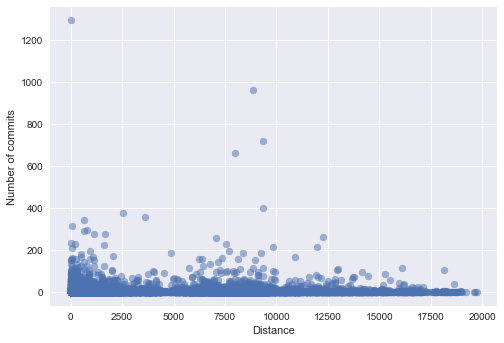

In [22]:
# scatter plot: distance vs. number of commits
#df = github.copy()
df = github.loc[github['commiter_city'] != github['owner_city']].copy()

plt.style.use('seaborn')
plt.scatter(df.distance, df.number_commits, alpha=0.5)
plt.xlabel('Distance')
plt.ylabel('Number of commits')

## Merging GitHub and CEPII datasets, running the regression

Preparing CEPII data 

In [23]:
# we import the cepii csv file directly in the memory as a dataframe using pandas read_csv function. 

cepii = pd.read_csv("gravdata.csv")
cepii.head()

,iso2_o,iso2_d,contig,distw,pop_o,pop_d,gdp_o,gdp_d,tdiff,eu_o,eu_d,comlang
0,AD,AD,0,11.227382,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0
1,AE,AD,0,5239.465258,9.156963,NaN,3.702963e+11,NaN,3.0,0.0,0.0,0
2,AF,AD,0,5712.403090,32.526562,NaN,1.933129e+10,NaN,3.5,0.0,0.0,0
3,AG,AD,0,6574.278311,0.091818,NaN,1.259259e+09,NaN,5.0,0.0,0.0,0
4,AI,AD,0,6593.264971,NaN,NaN,NaN,NaN,5.0,0.0,0.0,0


In [24]:
# basic summary statistics
cepii.describe()

,contig,distw,pop_o,pop_d,gdp_o,gdp_d,tdiff,eu_o,eu_d,comlang
count,50176.000000,50176.000000,44576.000000,44576.000000,4.278400e+04,4.278400e+04,50176.000000,49952.000000,49952.000000,50176.000000
mean,0.012277,8484.354990,36.786091,36.786091,3.865319e+11,3.865319e+11,5.018841,0.125000,0.125000,0.201849
std,0.110120,4694.366258,138.605756,138.605756,1.599477e+12,1.599477e+12,3.497312,0.330722,0.330722,0.401384
min,0.000000,0.995137,0.009916,0.009916,3.267328e+07,3.267328e+07,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4765.499750,1.360088,1.360088,6.699204e+09,6.699204e+09,2.000000,0.000000,0.000000,0.000000
50%,0.000000,8095.464147,7.305700,7.305700,3.299769e+10,3.299769e+10,5.000000,0.000000,0.000000,0.000000
75%,0.000000,11993.445567,25.155317,25.155317,1.948513e+11,1.948513e+11,8.000000,0.000000,0.000000,0.000000
max,1.000000,19888.656250,1371.219971,1371.219971,1.803665e+13,1.803665e+13,12.000000,1.000000,1.000000,1.000000


In [25]:
# rename iso2_o and iso2_d to avoid confusion (unlike stata, it is not necessary to have the same column names for merging)
cepii = cepii.rename(columns={"iso2_d" : "owner_country", "iso2_o": "commiter_country"})

#change subscripts _o and _c in column names
cepii.columns = [x.replace("_o", "_commiter").replace("_d", "_owner") for x in cepii.columns]
cepii.head()

,commiter_country,owner_country,contig,distw,pop_commiter,pop_owner,gdp_commiter,gdp_owner,tdiff,eu_commiter,eu_owner,comlang
0,AD,AD,0,11.227382,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0
1,AE,AD,0,5239.465258,9.156963,NaN,3.702963e+11,NaN,3.0,0.0,0.0,0
2,AF,AD,0,5712.403090,32.526562,NaN,1.933129e+10,NaN,3.5,0.0,0.0,0
3,AG,AD,0,6574.278311,0.091818,NaN,1.259259e+09,NaN,5.0,0.0,0.0,0
4,AI,AD,0,6593.264971,NaN,NaN,NaN,NaN,5.0,0.0,0.0,0


In [26]:
#make country codes lower case
for x in ["commiter_country", "owner_country"]:
    cepii[x] = cepii[x].str.lower() #we take a column cepii['commiter_country'] and apply a string function str.lower() 

In [27]:
cepii.head()

,commiter_country,owner_country,contig,distw,pop_commiter,pop_owner,gdp_commiter,gdp_owner,tdiff,eu_commiter,eu_owner,comlang
0,ad,ad,0,11.227382,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0
1,ae,ad,0,5239.465258,9.156963,NaN,3.702963e+11,NaN,3.0,0.0,0.0,0
2,af,ad,0,5712.403090,32.526562,NaN,1.933129e+10,NaN,3.5,0.0,0.0,0
3,ag,ad,0,6574.278311,0.091818,NaN,1.259259e+09,NaN,5.0,0.0,0.0,0
4,ai,ad,0,6593.264971,NaN,NaN,NaN,NaN,5.0,0.0,0.0,0


In [28]:
#merge with github data from your new  SQL queries
#note: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
#inner merge is also default in pandas (if you don't change the default, not needed to specify this parameter)

merged = pd.merge(github, cepii, on = ['commiter_country', 'owner_country'], how = 'inner')
merged.head()

,commiter_country,commiter_city,commiter_lat,commiter_long,owner_country,owner_city,owner_lat,owner_long,number_commits,owner_loc,...,contig,distw,pop_commiter,pop_owner,gdp_commiter,gdp_owner,tdiff,eu_commiter,eu_owner,comlang
0,ae,Dubai,25.201675,55.154205,de,Leipzig,51.339695,12.373075,3,"(51.3396955, 12.3730747)",...,0,4823.589034,9.156963,81.413147,3.702963e+11,3.363447e+12,3.0,0.0,1.0,0
1,ae,Dubai,25.204849,55.270783,de,None,51.202465,10.382203,1,"(51.20246506, 10.3822031)",...,0,4823.589034,9.156963,81.413147,3.702963e+11,3.363447e+12,3.0,0.0,1.0,0
2,ae,Dubai,25.201675,55.154205,fr,Lille,50.619499,3.061240,59,"(50.61949921, 3.06123996)",...,0,5180.429650,9.156963,66.808388,3.702963e+11,2.418835e+12,3.0,0.0,1.0,0
3,ae,None,23.684776,54.536644,in,Bengaluru,12.966970,77.587280,1,"(12.96697044, 77.58728027)",...,0,2318.754580,9.156963,1311.050537,3.702963e+11,2.095398e+12,1.5,0.0,0.0,0
4,ae,Dubai,25.175560,55.153889,ir,Tehran,35.689197,51.388974,22,"(35.6891975, 51.3889736)",...,0,1178.390029,9.156963,79.109268,3.702963e+11,4.253261e+11,0.5,0.0,0.0,0


You are now almost ready to run the gravity model on the merged dataset. 

Modify the code below. 

<div class="alert alert-block alert-info">
<b></b> 
    
   1) Log transform the relevant variables 
    
   2) Run a simple OLS model (as in the lecture): 
    
        - Which coefficient for distance do you get?
        - If you have time: which coefficient for the country border do you get? 
        Note: you will need to create a variable for that.
  
    
</div>

In [75]:
# create a copy to play, just in case 
merged_T = merged.copy()
merged_T.head()


,commiter_country,commiter_city,commiter_lat,commiter_long,owner_country,owner_city,owner_lat,owner_long,number_commits,owner_loc,...,contig,distw,pop_commiter,pop_owner,gdp_commiter,gdp_owner,tdiff,eu_commiter,eu_owner,comlang
0,ae,Dubai,25.201675,55.154205,de,Leipzig,51.339695,12.373075,3,"(51.3396955, 12.3730747)",...,0,4823.589034,9.156963,81.413147,3.702963e+11,3.363447e+12,3.0,0.0,1.0,0
1,ae,Dubai,25.204849,55.270783,de,None,51.202465,10.382203,1,"(51.20246506, 10.3822031)",...,0,4823.589034,9.156963,81.413147,3.702963e+11,3.363447e+12,3.0,0.0,1.0,0
2,ae,Dubai,25.201675,55.154205,fr,Lille,50.619499,3.061240,59,"(50.61949921, 3.06123996)",...,0,5180.429650,9.156963,66.808388,3.702963e+11,2.418835e+12,3.0,0.0,1.0,0
3,ae,None,23.684776,54.536644,in,Bengaluru,12.966970,77.587280,1,"(12.96697044, 77.58728027)",...,0,2318.754580,9.156963,1311.050537,3.702963e+11,2.095398e+12,1.5,0.0,0.0,0
4,ae,Dubai,25.175560,55.153889,ir,Tehran,35.689197,51.388974,22,"(35.6891975, 51.3889736)",...,0,1178.390029,9.156963,79.109268,3.702963e+11,4.253261e+11,0.5,0.0,0.0,0


In [76]:
merged_T.describe()

,commiter_lat,commiter_long,owner_lat,owner_long,number_commits,distance,contig,distw,pop_commiter,pop_owner,gdp_commiter,gdp_owner,tdiff,eu_commiter,eu_owner,comlang
count,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9717.000000,9718.000000,9.716000e+03,9.716000e+03,9719.000000,5857.000000,5857.000000,9719.000000
mean,36.650294,-17.991467,35.491183,-12.941918,9.650478,4511.844646,0.061838,4635.996424,230.438972,254.451440,7.214253e+12,6.872861e+12,3.405197,0.446304,0.371692,0.153720
std,21.513804,74.608681,22.001521,76.744874,40.762010,4581.118911,0.240873,4430.627902,318.260433,358.124271,7.739367e+12,7.653475e+12,3.892058,0.497151,0.483298,0.360698
min,-44.056293,-157.858333,-45.878760,-157.858333,1.000000,0.000000,0.000000,8.449664,0.055070,0.031781,9.840740e+08,9.840740e+08,0.000000,0.000000,0.000000,0.000000
25%,34.409857,-83.748466,32.321458,-81.955090,1.000000,466.507590,0.000000,1018.070883,37.999493,35.851772,8.619340e+11,7.502839e+11,0.000000,0.000000,0.000000,0.000000
50%,41.504749,-0.127758,40.712775,2.213749,2.000000,2423.290632,0.000000,1853.802467,81.413147,91.605942,2.858003e+12,2.418835e+12,1.000000,0.000000,0.000000,0.000000
75%,50.629250,16.273360,49.443232,23.865302,7.000000,8061.577855,0.000000,7595.451783,321.418823,321.418823,1.803665e+13,1.803665e+13,7.500000,1.000000,1.000000,0.000000
max,69.649205,176.165130,69.683296,178.018005,2684.000000,19731.391233,1.000000,19539.478216,1371.219971,1371.219971,1.803665e+13,1.803665e+13,12.000000,1.000000,1.000000,1.000000


_Hint_ 

* log the variables (one possible way)
        for x in [list of the relevant column indices]:
            merged_T.iloc[:, x] = np.log(merged_T.iloc[:,x]+1)
* inverse hyperbolic sine - np.arcsinh() works in a similar way

In [77]:
# do the necessary transformation 
for x in ['number_commits', 'distance', 'pop_commiter', 'pop_owner', 'gdp_commiter', 'gdp_owner']:
      merged_T[f'log_{x}'] = np.log(merged_T[x]+1) 
      merged_T[f'asinh_{x}'] = np.arcsinh(merged_T[x]+1) 
        # we add 1 to avoid turning zero-values to missing. Note that it is not the best solution !
        # somewhat better alternative in the presence of zeros: inverse hyperbolic sine transformation, which is well-defined at zero.

# check the result
merged_T.describe()

,commiter_lat,commiter_long,owner_lat,owner_long,number_commits,distance,contig,distw,pop_commiter,pop_owner,...,log_distance,asinh_distance,log_pop_commiter,asinh_pop_commiter,log_pop_owner,asinh_pop_owner,log_gdp_commiter,asinh_gdp_commiter,log_gdp_owner,asinh_gdp_owner
count,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9717.000000,9718.000000,...,9719.000000,9719.000000,9717.000000,9717.000000,9718.000000,9718.000000,9716.000000,9716.000000,9716.000000,9716.000000
mean,36.650294,-17.991467,35.491183,-12.941918,9.650478,4511.844646,0.061838,4635.996424,230.438972,254.451440,...,6.958838,7.666569,4.610098,5.304144,4.626864,5.320963,28.635089,29.328237,28.559577,29.252724
std,21.513804,74.608681,22.001521,76.744874,40.762010,4581.118911,0.240873,4430.627902,318.260433,358.124271,...,2.751134,2.714840,1.433592,1.431691,1.503381,1.501470,1.676270,1.676270,1.674461,1.674461
min,-44.056293,-157.858333,-45.878760,-157.858333,1.000000,0.000000,0.000000,8.449664,0.055070,0.031781,...,0.000000,0.881374,0.053607,0.919783,0.031286,0.903669,20.707212,21.400359,20.707212,21.400359
25%,34.409857,-83.748466,32.321458,-81.955090,1.000000,466.507590,0.000000,1018.070883,37.999493,35.851772,...,6.147416,6.840564,3.663549,4.356860,3.606904,4.300235,27.482445,28.175592,27.343718,28.036865
50%,41.504749,-0.127758,40.712775,2.213749,2.000000,2423.290632,0.000000,1853.802467,81.413147,91.605942,...,7.793294,8.486441,4.411745,5.104929,4.528353,5.221529,28.681144,29.374291,28.514307,29.207455
75%,50.629250,16.273360,49.443232,23.865302,7.000000,8061.577855,0.000000,7595.451783,321.418823,321.418823,...,8.994989,9.688136,5.775851,6.469001,5.775851,6.469001,30.523427,31.216574,30.523427,31.216574
max,69.649205,176.165130,69.683296,178.018005,2684.000000,19731.391233,1.000000,19539.478216,1371.219971,1371.219971,...,9.890017,10.583164,7.224185,7.917332,7.224185,7.917332,30.523427,31.216574,30.523427,31.216574


In [78]:
# dummy for a foreign country (border effect)
merged_T['foreign'] = np.where(merged_T.owner_country == merged_T.commiter_country ,0,1)

In [79]:
merged_T.describe()

,commiter_lat,commiter_long,owner_lat,owner_long,number_commits,distance,contig,distw,pop_commiter,pop_owner,...,asinh_distance,log_pop_commiter,asinh_pop_commiter,log_pop_owner,asinh_pop_owner,log_gdp_commiter,asinh_gdp_commiter,log_gdp_owner,asinh_gdp_owner,foreign
count,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9717.000000,9718.000000,...,9719.000000,9717.000000,9717.000000,9718.000000,9718.000000,9716.000000,9716.000000,9716.000000,9716.000000,9719.000000
mean,36.650294,-17.991467,35.491183,-12.941918,9.650478,4511.844646,0.061838,4635.996424,230.438972,254.451440,...,7.666569,4.610098,5.304144,4.626864,5.320963,28.635089,29.328237,28.559577,29.252724,0.602634
std,21.513804,74.608681,22.001521,76.744874,40.762010,4581.118911,0.240873,4430.627902,318.260433,358.124271,...,2.714840,1.433592,1.431691,1.503381,1.501470,1.676270,1.676270,1.674461,1.674461,0.489378
min,-44.056293,-157.858333,-45.878760,-157.858333,1.000000,0.000000,0.000000,8.449664,0.055070,0.031781,...,0.881374,0.053607,0.919783,0.031286,0.903669,20.707212,21.400359,20.707212,21.400359,0.000000
25%,34.409857,-83.748466,32.321458,-81.955090,1.000000,466.507590,0.000000,1018.070883,37.999493,35.851772,...,6.840564,3.663549,4.356860,3.606904,4.300235,27.482445,28.175592,27.343718,28.036865,0.000000
50%,41.504749,-0.127758,40.712775,2.213749,2.000000,2423.290632,0.000000,1853.802467,81.413147,91.605942,...,8.486441,4.411745,5.104929,4.528353,5.221529,28.681144,29.374291,28.514307,29.207455,1.000000
75%,50.629250,16.273360,49.443232,23.865302,7.000000,8061.577855,0.000000,7595.451783,321.418823,321.418823,...,9.688136,5.775851,6.469001,5.775851,6.469001,30.523427,31.216574,30.523427,31.216574,1.000000
max,69.649205,176.165130,69.683296,178.018005,2684.000000,19731.391233,1.000000,19539.478216,1371.219971,1371.219971,...,10.583164,7.224185,7.917332,7.224185,7.917332,30.523427,31.216574,30.523427,31.216574,1.000000


In [80]:
# defining dummies for different distance ranges
merged_T['distance'].loc[merged_T.distance.between(50,200, inclusive = 'left')].describe()

count    444.000000
mean     121.851527
std       45.577931
min       50.050985
25%       80.892542
50%      118.812110
75%      163.358008
max      199.871229
Name: distance, dtype: float64

In [81]:
# assigning values based on conditions
conditions = [
    (merged_T['distance'] < 5),
    (merged_T['distance'].between(5, 50, inclusive = 'left')), 
    (merged_T['distance'].between(50, 150, inclusive = 'left')), 
    (merged_T['distance'].between(150, 600, inclusive = 'left')), 
    (merged_T['distance'].between(600, 1000, inclusive = 'left')), 
    (merged_T['distance'].between(1000, 5000, inclusive = 'left')), 
    (merged_T['distance'] >=5000)  
    ]

# 2. example for one column Number of passenger 
values = [0, 50, 150, 600, 1000, 5000, 9999]

merged_T['Dist_d'] =  np.select(conditions, values) # will create a new column 


In [82]:
# dummies for distances
merged_T = pd.get_dummies(merged_T, columns=['Dist_d'], drop_first=True)
merged_T.describe()

,commiter_lat,commiter_long,owner_lat,owner_long,number_commits,distance,contig,distw,pop_commiter,pop_owner,...,asinh_gdp_commiter,log_gdp_owner,asinh_gdp_owner,foreign,Dist_d_50,Dist_d_150,Dist_d_600,Dist_d_1000,Dist_d_5000,Dist_d_9999
count,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9717.000000,9718.000000,...,9716.000000,9716.000000,9716.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000
mean,36.650294,-17.991467,35.491183,-12.941918,9.650478,4511.844646,0.061838,4635.996424,230.438972,254.451440,...,29.328237,28.559577,29.252724,0.602634,0.040539,0.030353,0.108447,0.074082,0.230168,0.417327
std,21.513804,74.608681,22.001521,76.744874,40.762010,4581.118911,0.240873,4430.627902,318.260433,358.124271,...,1.676270,1.674461,1.674461,0.489378,0.197230,0.171565,0.310961,0.261917,0.420962,0.493143
min,-44.056293,-157.858333,-45.878760,-157.858333,1.000000,0.000000,0.000000,8.449664,0.055070,0.031781,...,21.400359,20.707212,21.400359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.409857,-83.748466,32.321458,-81.955090,1.000000,466.507590,0.000000,1018.070883,37.999493,35.851772,...,28.175592,27.343718,28.036865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.504749,-0.127758,40.712775,2.213749,2.000000,2423.290632,0.000000,1853.802467,81.413147,91.605942,...,29.374291,28.514307,29.207455,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,50.629250,16.273360,49.443232,23.865302,7.000000,8061.577855,0.000000,7595.451783,321.418823,321.418823,...,31.216574,30.523427,31.216574,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,69.649205,176.165130,69.683296,178.018005,2684.000000,19731.391233,1.000000,19539.478216,1371.219971,1371.219971,...,31.216574,30.523427,31.216574,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [83]:
# square distance 
merged_T['log_distance2'] = merged_T['log_distance']**2
merged_T['log_distance3'] = merged_T['log_distance']**3

In [84]:
# import statsmodels package https://www.statsmodels.org/stable/index.html
import statsmodels.api as sm 

In [85]:
# our independent variables

merged_T[['log_distance', 'foreign', 'comlang', 'log_pop_commiter', 'log_pop_owner', 'log_gdp_commiter', 'log_gdp_owner', \
            'tdiff']]

,log_distance,foreign,comlang,log_pop_commiter,log_pop_owner,log_gdp_commiter,log_gdp_owner,tdiff
0,8.440520,1,0,2.318160,4.411745,26.637569,28.843987,3.0
1,8.468397,1,0,2.318160,4.411745,26.637569,28.843987,3.0
2,8.561909,1,0,2.318160,4.216686,26.637569,28.514307,3.0
3,7.902702,1,0,2.318160,7.179346,26.637569,28.370765,1.5
4,7.110053,1,0,2.318160,4.383392,26.637569,26.776122,0.5
...,...,...,...,...,...,...,...,...
9714,7.140911,0,0,4.024582,4.024582,26.474479,26.474479,0.0
9715,0.000000,0,0,4.024582,4.024582,26.474479,26.474479,0.0
9716,0.000000,0,0,4.024582,4.024582,26.474479,26.474479,0.0
9717,3.726184,0,0,4.024582,4.024582,26.474479,26.474479,0.0


In [86]:
# set X and Y
X = merged_T[['log_distance', 'foreign', 'comlang', 'log_pop_commiter', 'log_pop_owner', 'log_gdp_commiter', 'log_gdp_owner', \
            'tdiff']] #columns of merged_T corresponding to independent variables 
y = merged_T['log_number_commits']
X = sm.add_constant(X)

# do the estimation 
est = sm.OLS(y, X, missing='drop').fit()
est.summary() 
# can also use est.params, est.tvalues, est.pvalues ... will return vectors with coefficients and corresponding statistics

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_number_commits   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     107.9
Date:                Mon, 25 Oct 2021   Prob (F-statistic):          2.83e-173
Time:                        12:19:21   Log-Likelihood:                -13513.
No. Observations:                9713   AIC:                         2.704e+04
Df Residuals:                    9704   BIC:                         2.711e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.4842      0.278      5.345      0.000       0.940       2.029
log_distance        -0.1083      0.005    -20.043      0.000      -0.119      -0.098
foreign             -0.1011      0.036     -2.780      0.005      -0.172      -0.030
comlang             -0.0194      0.030     -0.657      0.511      -0.077       0.039
log_pop_commiter    -0.0399      0.013     -3.150      0.002      -0.065      -0.015
log_pop_owner       -0.0003      0.011     -0.029      0.977      -0.022       0.022
log_gdp_commiter     0.0310      0.011      2.848      0.004       0.010       0.052
log_gdp_owner        0.0037      0.010      0.361      0.718      -0.016       0.023
tdiff                0.0183      0.004      4.650      0.000       0.011       0.026
==============================================================================
Omnibus:                     2162.122   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4311.384
Skew:                           1.339   Prob(JB):                         0.00
Kurtosis:                       4.867   Cond. No.                     1.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Extensions if you have time  

<div class="alert alert-block alert-info">
<b></b> 
    
   Can you detect non-linearities in the distance effect? How can it be measured?
    
</div>

In [87]:
# squared distance
X = merged_T[['log_distance', 'log_distance2', 'log_distance3',
              'foreign', 'comlang', 'log_pop_commiter', 'log_pop_owner', 'log_gdp_commiter', 'log_gdp_owner', \
            'tdiff']] #columns of merged_T corresponding to independent variables 
y = merged_T['log_number_commits']
X = sm.add_constant(X)

# do the estimation 
est = sm.OLS(y, X, missing='drop').fit()
est.summary() 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_number_commits   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     88.14
Date:                Mon, 25 Oct 2021   Prob (F-statistic):          7.28e-175
Time:                        12:19:29   Log-Likelihood:                -13505.
No. Observations:                9713   AIC:                         2.703e+04
Df Residuals:                    9702   BIC:                         2.711e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.6440      0.282      5.837      0.000       1.092       2.196
log_distance        -0.2632      0.041     -6.415      0.000      -0.344      -0.183
log_distance2        0.0361      0.011      3.382      0.001       0.015       0.057
log_distance3       -0.0021      0.001     -2.895      0.004      -0.004      -0.001
foreign             -0.1360      0.038     -3.621      0.000      -0.210      -0.062
comlang             -0.0139      0.030     -0.468      0.640      -0.072       0.044
log_pop_commiter    -0.0422      0.013     -3.335      0.001      -0.067      -0.017
log_pop_owner       -0.0017      0.011     -0.147      0.884      -0.024       0.020
log_gdp_commiter     0.0305      0.011      2.800      0.005       0.009       0.052
log_gdp_owner        0.0019      0.010      0.190      0.850      -0.018       0.022
tdiff                0.0177      0.006      2.792      0.005       0.005       0.030
==============================================================================
Omnibus:                     2160.664   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4309.925
Skew:                           1.337   Prob(JB):                         0.00
Kurtosis:                       4.869   Cond. No.                     1.58e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
# non-linearities
X = merged_T[['Dist_d_50', 'Dist_d_150', 'Dist_d_600', 'Dist_d_1000', 'Dist_d_5000', 'Dist_d_9999', 'foreign', 'comlang', 'log_pop_commiter', 'log_pop_owner', 'log_gdp_commiter', 'log_gdp_owner', \
            'tdiff']] #columns of merged_T corresponding to independent variables 
y = merged_T['log_number_commits']
X = sm.add_constant(X)

# do the estimation 
est = sm.OLS(y, X, missing='drop').fit()
est.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_number_commits   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     65.62
Date:                Mon, 25 Oct 2021   Prob (F-statistic):          1.88e-166
Time:                        12:19:42   Log-Likelihood:                -13518.
No. Observations:                9713   AIC:                         2.706e+04
Df Residuals:                    9699   BIC:                         2.716e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.4996      0.280      5.355      0.000       0.951       2.048
Dist_d_50           -0.4480      0.058     -7.682      0.000      -0.562      -0.334
Dist_d_150          -0.6178      0.065     -9.516      0.000      -0.745      -0.491
Dist_d_600          -0.6563      0.044    -14.766      0.000      -0.743      -0.569
Dist_d_1000         -0.6574      0.052    -12.653      0.000      -0.759      -0.556
Dist_d_5000         -0.8135      0.042    -19.247      0.000      -0.896      -0.731
Dist_d_9999         -0.8214      0.064    -12.745      0.000      -0.948      -0.695
foreign             -0.1398      0.038     -3.663      0.000      -0.215      -0.065
comlang             -0.0235      0.030     -0.790      0.429      -0.082       0.035
log_pop_commiter    -0.0425      0.013     -3.346      0.001      -0.067      -0.018
log_pop_owner       -0.0043      0.011     -0.379      0.705      -0.026       0.018
log_gdp_commiter     0.0309      0.011      2.840      0.005       0.010       0.052
log_gdp_owner        0.0047      0.010      0.466      0.641      -0.015       0.025
tdiff                0.0014      0.007      0.214      0.831      -0.012       0.015
==============================================================================
Omnibus:                     2159.727   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4302.926
Skew:                           1.338   Prob(JB):                         0.00
Kurtosis:                       4.864   Cond. No.                     1.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""



<div class="alert alert-block alert-info">
<b></b> 
    
   Discuss how you can further improve this analysis. If you have time, can try implementing some of your suggestions
       
        - Why is OLS with log-transformed variables not the best option? What are the main risks of this approach? What alternatives to OLS can be implemented? 
        - Additional controls? (Note: we used gdp and population at the country level to account for the fact that bigger countries could have more collaborations, what can we use at the city level?)
        - Fixed effects?   
    
</div>
   


<div class="alert alert-block alert-info">   
    
I encourage you to work on the problem set in teams. In the end, please, submit your responses to the form below (one form per team is enough) by <b>Monday, October 25. </b> 
    
If you tried to solve a question, but could not manage, please, write 'Can't solve (you can also specify a problem)'. The responses are anonymous and non-mandatory, but your feedback is extremely helpful :)  I will spend the first 15 minutes of our class on October 26 to go through the problem set and your questions. Solutions will be available after that. 
   

</div>

**Form to submit answers to the Problem Set** 
*  https://forms.gle/6hTyYSuncACgwzar9

## Resources

https://www.sqlitetutorial.net/

https://towardsdatascience.com/top-sql-queries-for-interview-b563cfec66d0

https://blog.sqlauthority.com/category/sql-puzzle/

https://sqlzoo.net/ 

https://www.datacamp.com/community/tutorials/sql-tutorial-query

https://mode.com/blog/learning-python-sql/ 

Markdown cheat sheet for Jupyter Notebook https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed